In [239]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as vision_F

import numpy as np

from torch.utils.data import Dataset, DataLoader

from torchvision.models.resnet import BasicBlock, Bottleneck, conv1x1

from torch import Tensor
from typing import Union, Type, List, Optional, Callable

from utils.networks import build_resnet18

import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [240]:
train_dataset = torchvision.datasets.CIFAR10('dataset')

class OneImageDataset(Dataset):
    def __init__(self, size):
        self.img = transforms.ToTensor()(train_dataset[0][0])
        self.size = size

    def __len__(self,):
        return self.size
    
    def __getitem__(self, i):
        return self.img

def one_image_dataloader(num_steps, batch_size):

    return DataLoader(
        OneImageDataset(num_steps*batch_size),
        batch_size,
    )

In [241]:
class DecoderRNN(nn.Module):
    def __init__(
            self,
            embed_size, 
            encoder_dim, 
            decoder_dim,
            num_transforms=4,
            num_discrete_magnitude=11,
            seq_length=10,
            drop_prob=0.3
        ):
        super().__init__()
        
        #save the model param
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim

        self.num_transforms = num_transforms
        self.num_discrete_magnitude = num_discrete_magnitude
        self.seq_length = seq_length

        
        self.action_embd = nn.Embedding(3, embed_size)
        self.branch_embd = nn.Embedding(2, embed_size)

        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)        
        
        self.fcn_transform = nn.Linear(decoder_dim,num_transforms)
        self.fcn_magnitude = nn.Linear(decoder_dim,num_discrete_magnitude)

        self.drop = nn.Dropout(drop_prob)

        self.value_net_1 = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.value_net_2 = nn.Linear(256, 1)

    

    def init_hidden_state(self, batch_size):
        h = torch.zeros(batch_size, self.decoder_dim, device=device)
        c = torch.zeros(batch_size, self.decoder_dim, device=device)
        return h, c
    

    def forward(self, z1):

        #get the seq length to iterate
        seq_length = self.seq_length
        batch_size = z1.size(0)
                
        # Initialize LSTM state
        h, c = self.init_hidden_state(batch_size)  # (batch_size, decoder_dim)
        
        preds_transform = torch.zeros(batch_size, 1, seq_length, self.num_transforms).to(device)
        preds_magnitude = torch.zeros(batch_size, 1, seq_length, self.num_discrete_magnitude).to(device)

        transform_action_id = torch.full((batch_size,), 0, dtype=torch.long, device=device)
        magnitude_action_id = torch.full((batch_size,), 1, dtype=torch.long, device=device)

        branch_id = torch.full((batch_size,2), 0, dtype=torch.long, device=device)
        branch_id[:, 1] = 0

        transform_action_embd = self.action_embd(transform_action_id)
        magnitude_action_embd = self.action_embd(magnitude_action_id)
        
        features = [z1]
        
        for branch in range(1):
            for step in range(seq_length):

                lstm_input = torch.cat((transform_action_embd, features[branch]), dim=-1)
                h, c = self.lstm_cell(lstm_input, (h, c))
                output_transform = self.fcn_transform(self.drop(h))

                lstm_input = torch.cat((magnitude_action_embd, features[branch]), dim=-1)
                h, c = self.lstm_cell(lstm_input, (h, c))
                output_magnitude = self.fcn_magnitude(self.drop(h))
                
                preds_transform[:, branch, step] = output_transform
                preds_magnitude[:, branch, step] = output_magnitude
        

        # print(h.min().item(), h.mean().item(), h.max().item())

        value1 = self.value_net_1(h)
        # print(value1.min().item(), value1.mean().item(), value1.max().item())
        # value = self.value_net_2(self.relu(value1))
        # print(value.min().item(), value.mean().item(), value.max().item())
        # print('-'*20)


        preds_transform = preds_transform.softmax(axis=-1)
        preds_magnitude = preds_magnitude.softmax(axis=-1)

        return preds_transform, preds_magnitude, value1

In [242]:
TRANSFORMS_DICT = [
    ('brightness', vision_F.adjust_brightness, (0.0, 2)),
    ('contrast', vision_F.adjust_contrast, (0.1, 1.9)),
    ('saturation', vision_F.adjust_saturation, (0.1, 1.9)),
    ('hue', vision_F.adjust_hue, (-0.45, 0.45)),
]

def get_transforms_list(actions_transform, actions_magnitude):

    all_transform_lists = []
    for i in range(actions_transform.size(0)):
        for branch in range(actions_transform.size(1)):
            transform_list = []
            for s in range(actions_transform.size(2)):
                transform_id = actions_transform[i, branch, s].item()
                magnitude_id = actions_magnitude[i, branch, s].item()
                func_name, func, (lower, upper) = TRANSFORMS_DICT[transform_id]
                step = (upper - lower) / 4
                magnitude = np.arange(start=lower, stop=upper+step, step=step)[magnitude_id]
                transform_list.append((func_name, func, round(magnitude, 5)))
            all_transform_lists.append(transform_list)

    return all_transform_lists


def apply_transformations(x1, transform_list):

    num_samples = x1.size(0)
    stored_imgs = torch.zeros((num_samples, 3, 32, 32))

    for i in range(x1.size(0)):
        img = x1[i]
        # print('-----')
        for transform_name, transform_func, magnitude in transform_list[i]:
            # print('before:',img.max())
            img = transform_func(img, magnitude)
            # print('after:',img.max())
        stored_imgs[i] = img

    return stored_imgs


In [243]:
def multi_dimensional_multinomial(x):
    *leading_axes, last_ax = x.shape
    x = x.reshape((-1, last_ax))
    actions = torch.multinomial(x, 1)
    actions = actions.reshape(leading_axes)
    return actions


def collect_trajectories(len_trajectory, encoder, decoder, batch_size):

    assert len_trajectory % batch_size == 0

    data_loader = one_image_dataloader(
        num_steps=len_trajectory // batch_size,
        batch_size=batch_size
    )

    encoder_dim = 512


    stored_z = torch.zeros((len_trajectory, encoder_dim))
    stored_value = torch.zeros((len_trajectory,))
    stored_preds_transform = torch.zeros((len_trajectory, 1, decoder.seq_length, decoder.num_transforms))
    stored_preds_magnitude = torch.zeros((len_trajectory, 1, decoder.seq_length, decoder.num_discrete_magnitude))
    stored_actions_transform = torch.zeros((len_trajectory, 1, decoder.seq_length, 1), dtype=torch.long)
    stored_actions_magnitude = torch.zeros((len_trajectory, 1, decoder.seq_length, 1), dtype=torch.long)
    stored_rewards = torch.zeros((len_trajectory,))

    data_loader_iterator = iter(data_loader)
    for i in range(len_trajectory // batch_size):
    # for i in tqdm(range(len_trajectory // batch_size)):

        begin, end = i*batch_size, (i+1)*batch_size

        img = next(data_loader_iterator)

        img = img.to(device)

        with torch.no_grad():
            logits, z = encoder(img)

        with torch.no_grad():
            preds_transform, preds_magnitude, value = decoder(z)

        actions_transform = preds_transform.argmax(dim=-1).unsqueeze(-1)
        # actions_magnitude = preds_magnitude.argmax(dim=-1).unsqueeze(-1)
        actions_magnitude = multi_dimensional_multinomial(preds_magnitude).unsqueeze(-1)
        transforms_list = get_transforms_list(actions_transform, actions_magnitude)
        # print(transforms_list[0])      
        new_img = apply_transformations(img, transforms_list)

        # print(img[:, 0, 0, 0], new_img[:, 0, 0, 0])

        # with torch.no_grad():
        #     new_logits, new_z = encoder(new_img)


        stored_z[begin:end] = z.detach().cpu()
        stored_value[begin:end] = value.reshape(-1).detach().cpu()
        stored_preds_transform[begin:end] = preds_transform.detach().cpu()
        stored_preds_magnitude[begin:end] = preds_magnitude.detach().cpu()
        stored_actions_transform[begin:end] = actions_transform.detach().cpu()
        stored_actions_magnitude[begin:end] = actions_magnitude.detach().cpu()
        stored_rewards[begin:end] = 1 - new_img.reshape(batch_size, -1).mean(axis=1)

    return (
            stored_z, stored_value, 
            (stored_preds_transform, stored_preds_magnitude),
            (stored_actions_transform, stored_actions_magnitude),
            stored_rewards
        ), (img, new_img)

# trajectory = collect_trajectories(1024, encoder, decoder, 1024)

In [244]:
def shuffle_trajectory(trajectory):

    (
        stored_z, stored_value, 
        (stored_preds_transform, stored_preds_magnitude),
        (stored_actions_transform, stored_actions_magnitude),
        stored_rewards
    ) = trajectory

    permutation = torch.randperm(stored_z.size()[0])

    random_stored_z = stored_z[permutation]
    random_stored_value = stored_value[permutation]
    random_stored_preds_transform = stored_preds_transform[permutation]
    random_stored_preds_magnitude = stored_preds_magnitude[permutation]
    random_stored_actions_transform = stored_actions_transform[permutation]
    random_stored_actions_magnitude = stored_actions_magnitude[permutation]
    random_stored_rewards = stored_rewards[permutation]

    random_trajectory = (
        random_stored_z, random_stored_value,
        (random_stored_preds_transform, random_stored_preds_magnitude),
        (random_stored_actions_transform, random_stored_actions_magnitude),
        random_stored_rewards
    )

    return random_trajectory

In [251]:
def calculate_entropy(probabilities):
    epsilon = 1e-12
    log_probabilities = torch.log(probabilities + epsilon)
    entropy = -torch.sum(probabilities * log_probabilities, dim=-1)
    return entropy

def ppo_update(trajectory, decoder, optimizer, value_criterion, ppo_batch_size=256):

    shuffled_trajectory = shuffle_trajectory(trajectory)

    (
        stored_z, stored_value,
        (stored_preds_transform, stored_preds_magnitude),
        (stored_actions_transform, stored_actions_magnitude),
        stored_rewards
    ) = shuffled_trajectory

    len_trajectory = stored_z.shape[0]


    assert len_trajectory % ppo_batch_size == 0

    acc_loss = 0
    for i in range(len_trajectory // ppo_batch_size):

        begin, end = i*ppo_batch_size, (i+1)*ppo_batch_size

        z = stored_z[begin:end].to(device)
        old_preds_transform = stored_preds_transform[begin:end].to(device)
        old_preds_magnitude = stored_preds_magnitude[begin:end].to(device)
        old_actions_transform = stored_actions_transform[begin:end].to(device)
        old_actions_magnitude = stored_actions_magnitude[begin:end].to(device)
        reward = stored_rewards[begin:end].to(device)

        new_preds_transform, new_preds_magnitude, new_value = decoder(z)
        new_value = new_value.reshape(-1)
        
        entropy_loss = calculate_entropy(new_preds_transform).mean() + calculate_entropy(new_preds_magnitude).mean()
        entropy_loss = -1. *  entropy_loss

        # print('entropy:', entropy.item())

        

        # print(old_preds_transform.sum(axis=-1).mean())
        # print(old_preds_magnitude.sum(axis=-1).mean())
        # print(new_preds_transform.sum(axis=-1).mean())
        # print(new_preds_magnitude.sum(axis=-1).mean())


        old_pi = torch.concatenate((
            old_preds_transform.gather(-1, old_actions_transform),
            old_preds_magnitude.gather(-1, old_actions_magnitude)
        ), dim=-1)

        new_pi = torch.concatenate((
            new_preds_transform.gather(-1, old_actions_transform),
            new_preds_magnitude.gather(-1, old_actions_magnitude)
        ), dim=-1)


        old_pi = old_pi.reshape(ppo_batch_size, -1)
        new_pi = new_pi.reshape(ppo_batch_size, -1)

        # print(new_pi.shape, old_pi.shape)

        advantage = reward
        advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
        # print(reward)
        advantage = advantage.unsqueeze(-1)
        ratio = torch.exp(torch.log(new_pi) - torch.log(old_pi).detach())

        # print(advantage.min(), advantage.max())

        # print('ratio:', ratio.shape)
        # print('advantage:', advantage.shape)

        # print(ratio)

        surr1 = ratio * advantage
        surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage

        actor_loss = - torch.min(surr1, surr2).mean()
        # value_loss = value_criterion(new_value, reward)

        
        # print('actor_loss:', actor_loss.item())
        # print('value_loss:', value_loss.item())
        # print('new_value:', new_value.mean())
        # print('reward:', reward.mean())


        loss = actor_loss + 0.05*entropy_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc_loss += loss.item()

    return acc_loss / (i+1)
    

---

In [252]:
def init():

    encoder = build_resnet18()
    encoder.load_state_dict(torch.load('resnet18-f37072fd.pth'))
    encoder = encoder.to(device)

    decoder = DecoderRNN(
        embed_size=1024,
        encoder_dim=512,
        decoder_dim=512,
        num_transforms=4,
        num_discrete_magnitude=5,
        seq_length=4
    ).to(device)

    optimizer = torch.optim.Adam(
        decoder.parameters(),
        lr=0.0005
    )

    value_criterion = nn.MSELoss()
    list(decoder.parameters())[-1]

    return encoder, decoder, optimizer, value_criterion

In [258]:
for _ in range(100):

    encoder, decoder, optimizer, value_criterion = init()

    rewards = []


    tqdm_range = tqdm(range(50))
    for step in tqdm_range:

        trajectory, (img, new_img) = collect_trajectories(
            len_trajectory=1024,
            encoder=encoder,
            decoder=decoder,
            batch_size=1024
        )

        loss = ppo_update(
            trajectory,
            decoder,
            optimizer,
            ppo_batch_size=1024,
            value_criterion=value_criterion
        )

        reward = float(trajectory[-1].mean())

        # print(f'Step: {step}      Reward: {reward:.6f}        Loss: {loss:.6f}')
        # print(trajectory[2][1][0])s

        tqdm_range.set_description(f'Step: {step}      Reward: {reward:.6f}        Loss: {loss:.6f}')

        rewards.append(reward)

        if reward == 1:
            break

    # break

Step: 6      Reward: 1.000000        Loss: -0.094071:  12%|█▏        | 6/50 [00:02<00:15,  2.85it/s]
Step: 4      Reward: 1.000000        Loss: -0.080622:   8%|▊         | 4/50 [00:01<00:21,  2.17it/s]
Step: 3      Reward: 1.000000        Loss: -0.082588:   6%|▌         | 3/50 [00:01<00:20,  2.32it/s]
Step: 4      Reward: 1.000000        Loss: -0.094084:   8%|▊         | 4/50 [00:02<00:24,  1.89it/s]
Step: 4      Reward: 1.000000        Loss: -0.073565:   8%|▊         | 4/50 [00:02<00:30,  1.49it/s]
Step: 4      Reward: 1.000000        Loss: -0.084688:   8%|▊         | 4/50 [00:01<00:22,  2.02it/s]
Step: 2      Reward: 1.000000        Loss: -0.096706:   4%|▍         | 2/50 [00:01<00:24,  1.92it/s]
Step: 2      Reward: 1.000000        Loss: -0.096505:   4%|▍         | 2/50 [00:00<00:22,  2.17it/s]
Step: 6      Reward: 1.000000        Loss: -0.099143:  12%|█▏        | 6/50 [00:03<00:28,  1.57it/s]
Step: 5      Reward: 1.000000        Loss: -0.082095:  10%|█         | 5/50 [00:03<00:27,  

KeyboardInterrupt: 

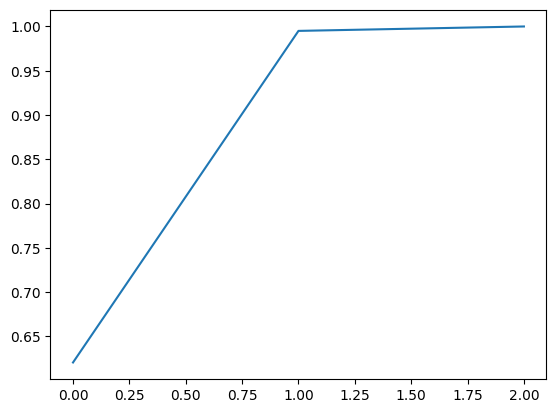

In [249]:
plt.plot(rewards)

In [250]:
a = torch.rand([1024, 1, 1, 4]).softmax(-1)
a[..., 1] = 100.
a[1, 0, 0, 0] = 20000.
multi_dimensional_multinomial(a)

tensor([[[1]],

        [[0]],

        [[1]],

        ...,

        [[1]],

        [[1]],

        [[1]]])